In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from scipy.sparse import coo_matrix

from qiskit import transpile, QuantumCircuit
from qiskit.quantum_info import hellinger_fidelity, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.result import sampled_expectation_value
from qiskit.visualization import plot_coupling_map
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Batch
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from calibration import Eagle
from cd_coefficients import eval_A, eval_B, eval_C, eval_D, first_order_cd_coeff
from scheduling_function import f, df
from bias_field import eval_hb, gs_rotation_angle
from dcqo import dcqo_circ, bf_dcqo_circ
from graph_utils import eagle_qubit_labels, eagle_qubit_coordinates, eagle_coupling_map, eagle_qubit_color

## Heavy-hex 118Q Ising model

In [2]:
entanglement_map_1 = Eagle.PROPERTIES.ENTANGLEMENT_MAP_1
entanglement_map_2 = Eagle.PROPERTIES.ENTANGLEMENT_MAP_2
entanglement_map_3 = Eagle.PROPERTIES.ENTANGLEMENT_MAP_3
bad_qubits = [23, 24, 25, 34, 118, 119, 120, 112, 126]

In [3]:
# 1st layer
edges_1 = []
for edge in entanglement_map_1:
    n1 = edge[0]
    n2 = edge[1]
    if (n1 in bad_qubits) or (n2 in bad_qubits):
        continue
    else:
        edges_1.append((n1, n2))

# 2nd layer
edges_2 = []
for edge in entanglement_map_2:
    n1 = edge[0]
    n2 = edge[1]
    if (n1 in bad_qubits) or (n2 in bad_qubits):
        continue
    else:
        edges_2.append((n1, n2))

# 3rd layer
edges_3 = []
for edge in entanglement_map_3:
    n1 = edge[0]
    n2 = edge[1]
    if (n1 in bad_qubits) or (n2 in bad_qubits):
        continue
    else:
        edges_3.append((n1, n2))

num_nodes = Eagle.PROPERTIES.NUM_QUBITS
num_nonzero_nodes = num_nodes - len(bad_qubits)
print(num_nonzero_nodes)
num_edges = len(edges_1 + edges_2 + edges_3)
print(num_edges)

118
130


In [4]:
# Hf
rng = np.random.default_rng(seed=42)
# mean, standard_deviation = 0, 1.0
hz_data = rng.standard_normal(size=num_nonzero_nodes)

row = np.array([e[0] for e in edges_1 + edges_2 + edges_3])
col = np.array([e[1] for e in edges_1 + edges_2 + edges_3])
# mean, standard_deviation = 0, 1.0
J_data = rng.standard_normal(size=num_edges)

J = coo_matrix((J_data, (row, col)), shape=(num_nodes, num_nodes))
J2 = coo_matrix((J_data ** 2, (row, col)), shape=(num_nodes, num_nodes))
J4 = coo_matrix((J_data ** 4, (row, col)), shape=(num_nodes, num_nodes))

In [5]:
hx = - np.ones(num_nodes)
for i in range(num_nodes):
    if i in bad_qubits:
        hx[i] = 0
    
hz = np.zeros(num_nodes)
k = 0
for i in range(num_nodes):
    if i in bad_qubits:
        continue
    else:
        hz[i] = hz_data[k]
        k += 1

In [6]:
pauli_list = []

for i, d in enumerate(hz):
    pauli_list.append(("Z", [i], d))

for i, j, d in zip(row, col, J_data):
    pauli_list.append(("ZZ", [i, j], d))

# via triples and local Paulis with indices
Hf = SparsePauliOp.from_sparse_list(pauli_list, num_qubits=num_nodes)
# print(Hf.to_matrix(sparse=True))

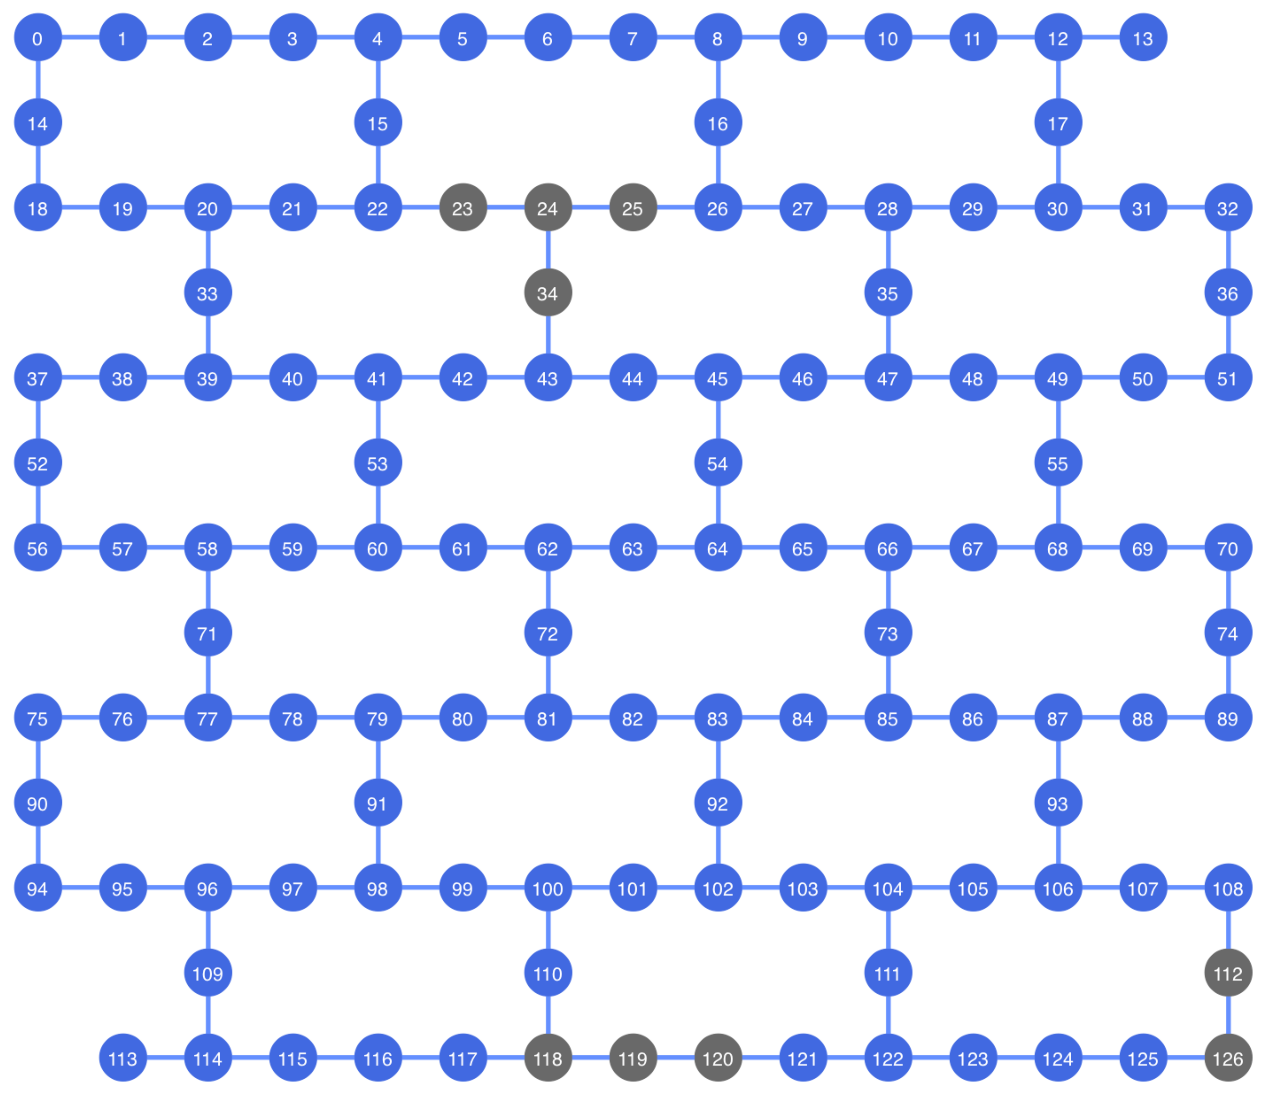

In [7]:
plot_coupling_map(
    num_qubits=num_nodes, 
    qubit_coordinates=eagle_qubit_coordinates(), 
    label_qubits=True, 
    coupling_map=eagle_coupling_map(), 
    qubit_color=eagle_qubit_color(eagle_qubit_labels(), bad_qubits),
    qubit_labels=eagle_qubit_labels(),
    font_size=16,
    qubit_size=48,
    # filename="eagle_ising_graph_118q.png",
)

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian without bias field
$$H_{ad} = (1 - \lambda) \sum_i h^x_i X_i + \lambda \left( \sum_i h^z_i Z_i + \sum_{i < j} J_{ij} Z_i Z_j \right)$$
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$
$$U(t) = \exp \left[- i \int^t_0 d \tau (H_{ad} + H_{cd}) \right]$$

In [8]:
# threshold for gate cutoff
threshold = 0.001
shots = 2 ** 13

service = QiskitRuntimeService(instance="client-enablement/its/its-skill-buildi")
layout = [i for i in range(num_nodes)]

In [9]:
backend = service.backend("ibm_brisbane")
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, initial_layout=layout)

## 1st iteration (without bias field)

In [10]:
hb = np.zeros(num_nodes)

T = 1
dt = 0.15
trotter_steps = [1, 2]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.007310038819959761, 0.10120449450040796]
[0.19084604805137834, 1.2040866472968799]
[-0.0747731769957699, -0.08918791240330805]
[0.028540330659777836, 0.21477994885021398]


In [11]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, J_data, y, dy, a1, threshold=threshold)
# circ.draw("mpl", fold=-1)
isa_circ = pm.run(circ)
# isa_circ.draw("mpl", fold=-1, idle_wires=False)

In [14]:
sampler = Sampler(backend, options={"default_shots": shots})
# sampler.options.resilience_level = 1
sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.dynamical_decoupling.sequence_type = "XpXm"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

job = sampler.run([isa_circ])
print(job.job_id())

cv64e50fkm5g008byqa0


In [12]:
hb = np.zeros(num_nodes)

T = 1
dt = 0.10
trotter_steps = [1, 2, 3]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688]
[-0.07390902966832542, -0.07702375266291062, -0.08918791240330805]
[0.008656383010949948, 0.06602278466906356, 0.21477994885021404]


In [13]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, J_data, y, dy, a1, threshold=threshold)
# circ.draw("mpl", fold=-1)
isa_circ = pm.run(circ)
# isa_circ.draw("mpl", fold=-1, idle_wires=False)

In [18]:
sampler = Sampler(backend, options={"default_shots": shots})
# sampler.options.resilience_level = 1
sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.dynamical_decoupling.sequence_type = "XpXm"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

job = sampler.run([isa_circ])
print(job.job_id())

cv64gpj1vt8g008vbg80


In [14]:
hb = np.zeros(num_nodes)

T = 1
dt = 0.10
trotter_steps = [1, 2, 3, 4]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796, 0.2667176834867113]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688, 2.0755709636919755]
[-0.07390902966832542, -0.07702375266291062, -0.08918791240330805, -0.11071574161900154]
[0.008656383010949948, 0.06602278466906356, 0.21477994885021404, 0.4595967570560456]


In [15]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, J_data, y, dy, a1, threshold=threshold)
# circ.draw("mpl", fold=-1)
isa_circ = pm.run(circ)
# isa_circ.draw("mpl", fold=-1, idle_wires=False)

In [22]:
sampler = Sampler(backend, options={"default_shots": shots})
# sampler.options.resilience_level = 1
sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.dynamical_decoupling.sequence_type = "XpXm"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

job = sampler.run([isa_circ])
print(job.job_id())

cv64jsv12hg0008wks4g


## Results

In [16]:
pauli_list = []

for i, d in enumerate(hz):
    pauli_list.append(("Z", [i], d))

for i, j, d in zip(row, col, data):
    pauli_list.append(("ZZ", [i, j], d))

# via triples and local Paulis with indices
Hf = SparsePauliOp.from_sparse_list(pauli_list, num_qubits=num_nodes)

### Sampler

In [23]:
# 2 Trotter steps
job = service.job("cv64e50fkm5g008byqa0")
result = job.result()
quasi_dist_2_steps = result[0].data.meas.get_counts()

# 3 Trotter steps
job = service.job("cv64gpj1vt8g008vbg80")
result = job.result()
quasi_dist_3_steps = result[0].data.meas.get_counts()

# 4 Trotter steps
job = service.job("cv64jsv12hg0008wks4g")
result = job.result()
quasi_dist_4_steps = result[0].data.meas.get_counts()

In [24]:
objective_2_steps = []
for k, p in quasi_dist_2_steps.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_2_steps.append(v)

objective_3_steps = []
for k, p in quasi_dist_3_steps.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_3_steps.append(v)

objective_4_steps = []
for k, p in quasi_dist_4_steps.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_4_steps.append(v)

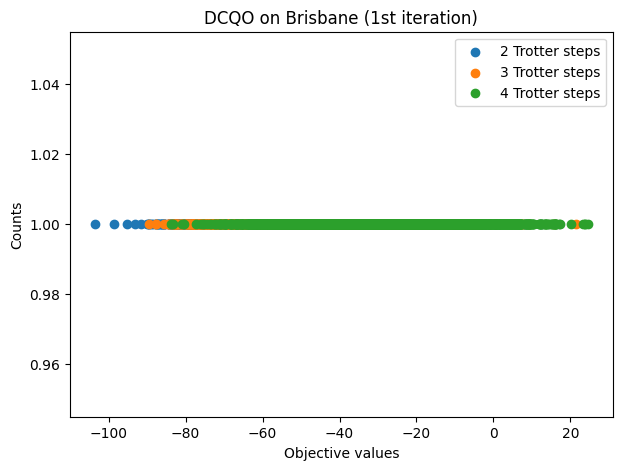

In [26]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_2_steps, quasi_dist_2_steps.values())
plt.scatter(objective_3_steps, quasi_dist_3_steps.values())
plt.scatter(objective_4_steps, quasi_dist_4_steps.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Counts")
plt.title("DCQO on Brisbane (1st iteration)")
plt.legend(["2 Trotter steps", "3 Trotter steps", "4 Trotter steps"])
plt.show()

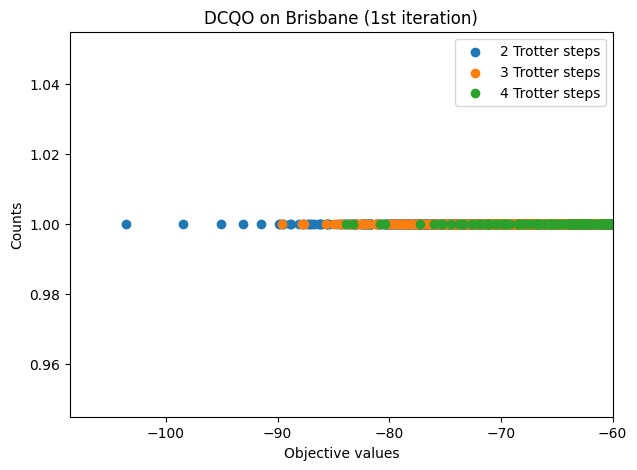

In [27]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_2_steps, quasi_dist_2_steps.values())
plt.scatter(objective_3_steps, quasi_dist_3_steps.values())
plt.scatter(objective_4_steps, quasi_dist_4_steps.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Counts")
plt.xlim(min(objective_2_steps) - 5, -60)
plt.title("DCQO on Brisbane (1st iteration)")
plt.legend(["2 Trotter steps", "3 Trotter steps", "4 Trotter steps"])
plt.show()

In [28]:
print(min(objective_2_steps))
print(min(objective_3_steps))
print(min(objective_4_steps))

-103.57699791716631
-89.57820414650391
-83.89696922017848


In [29]:
i = np.argmin(objective_2_steps)
print(objective_2_steps[i])
print(list(quasi_dist_2_steps.keys())[i])
print(list(quasi_dist_2_steps.values())[i])

i = np.argmin(objective_3_steps)
print(objective_3_steps[i])
print(list(quasi_dist_3_steps.keys())[i])
print(list(quasi_dist_3_steps.values())[i])

i = np.argmin(objective_4_steps)
print(objective_4_steps[i])
print(list(quasi_dist_4_steps.keys())[i])
print(list(quasi_dist_4_steps.values())[i])

-103.57699791716631
0010000010100111000101010000100000000110100010101000001001100101101010011010110011010011100011111000010011011000110110100001001
1
-89.57820414650391
1111111001100110001011100000011110001000111110111100001011100101101111011001111101010011100111111000011010101000001111111000100
1
-83.89696922017848
1110001000100101011010100100000001100111011110000000011011101000010101010100111000010011100011111001000010111000111110110100100
1


In [30]:
hb_2_steps = eval_hb(num_nodes, quasi_dist_2_steps)
print(hb_2_steps.tolist())

hb_3_steps = eval_hb(num_nodes, quasi_dist_3_steps)
print(hb_3_steps.tolist())

hb_4_steps = eval_hb(num_nodes, quasi_dist_4_steps)
print(hb_4_steps.tolist())

[0.027587890625, 0.353515625, -0.125732421875, 0.10498046875, 0.50634765625, 0.467041015625, -0.105712890625, 0.09033203125, 0.010498046875, 0.1748046875, -0.187744140625, -0.227783203125, 0.002685546875, -0.422119140625, -0.064208984375, 0.51171875, -0.00830078125, 0.26806640625, -0.17138671875, -0.02734375, -0.177978515625, 0.097412109375, -0.401611328125, -0.036865234375, -0.493896484375, -0.053955078125, 0.01953125, 0.103759765625, 0.010498046875, -0.06396484375, -0.21142578125, -0.24658203125, -0.2236328125, -0.51708984375, 0.003173828125, 0.074462890625, 0.197998046875, 0.3251953125, -0.262939453125, -0.461181640625, -0.09814453125, 0.150634765625, 0.287841796875, -0.17626953125, -0.176513671875, -0.19287109375, 0.217041015625, -0.052734375, -0.084716796875, -0.167236328125, -0.311767578125, -0.002685546875, -0.2978515625, 0.0771484375, -0.22216796875, -0.154296875, 0.398193359375, -0.04150390625, 0.1318359375, 0.06689453125, -0.033935546875, -0.10595703125, 0.336669921875, -0.21

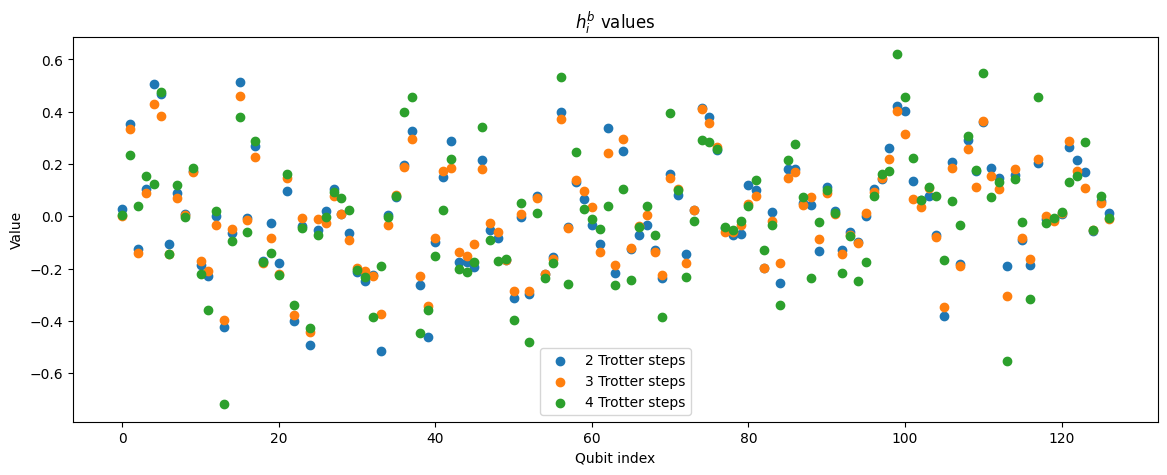

In [32]:
plt.figure(figsize=(14, 5))

plt.scatter(layout, hb_2_steps)
plt.scatter(layout, hb_3_steps)
plt.scatter(layout, hb_4_steps)

# plt.xticks(rotation=90)
plt.xlabel("Qubit index")
plt.ylabel("Value")
plt.title(r"$h^b_i$ values")
# plt.legend(["Step=1", "Step=2", "Step=3", "Step=4", "Step=5"])
plt.legend(["2 Trotter steps", "3 Trotter steps", "4 Trotter steps"])
plt.show()